In [1]:
import pandas as pd
DATA_SET_FILE ='./labeled_news.csv'
df = pd.read_csv(DATA_SET_FILE, header=None)
print(df[3])

0                          cnn
1                          cnn
2                          cnn
3                          cnn
4                          cnn
5                          cnn
6                          cnn
7                          cnn
8                          cnn
9                          cnn
10                         cnn
11                         cnn
12                         cnn
13                         cnn
14                         cnn
15                         cnn
16                         cnn
17                         cnn
18                         cnn
19                         cnn
20                         cnn
21                         cnn
22                         cnn
23                         cnn
24                         cnn
25                         cnn
26                         cnn
27                         cnn
28                         cnn
29                         cnn
                ...           
515                 techcrunch
516     

In [5]:
print(df[0].describe())
print(df[3].describe())

count    545.000000
mean       3.341284
std        2.090121
min        1.000000
25%        2.000000
50%        2.000000
75%        5.000000
max        8.000000
Name: 0, dtype: float64
count     545
unique     11
top       cnn
freq      132
Name: 3, dtype: object


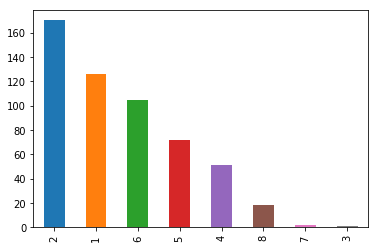

In [7]:
import matplotlib.pyplot as plt
plt.style.use='default'
df[0].value_counts().plot(kind='bar')

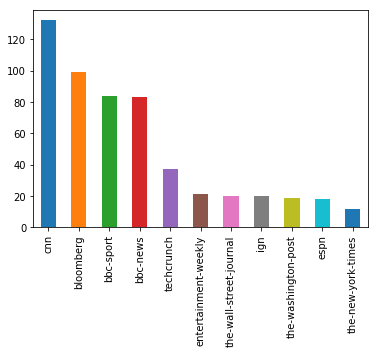

In [8]:
df[3].value_counts().plot(kind='bar')

In [9]:
import numpy as np
import tensorflow as tf

MAX_DOCUMENT_LENGTH = 5
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)

sentences=[
    "I like apple",
    "I like banana",
    "I eat apple"
]

embedded_sentences = np.array(list(vocab_processor.fit_transform(sentences)))
print(embedded_sentences)

print('Total unique words: %d' % len(vocab_processor.vocabulary_))


[[1 2 3 0 0]
 [1 2 4 0 0]
 [1 5 3 0 0]]
Total unique words: 6


In [15]:
print("")

new_sentences = [
    "This is a brand new sentence which we never seen before and is very long",
    "I hate doing homework!",
    "I like banana",
    "I eat apple"
]

new_embedded_sentences = np.array(list(vocab_processor.transform(new_sentences)))
print(new_embedded_sentences)

print('Total unique words: %d' % len(vocab_processor.vocabulary_))


[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 2 4 0 0]
 [1 5 3 0 0]]
Total unique words: 6


In [33]:
import tensorflow as tf

vocab_size = 6
embed_dim = 3

sentences = [
    [1,2,3,0,0]
]

embedded_sentences = tf.contrib.layers.embed_sequence(sentences, vocab_size, embed_dim)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(embedded_sentences)
    print(result)

[[[ 0.39272141  0.74528432 -0.68548799]
  [ 0.16277003  0.77496946 -0.29722255]
  [-0.32436803  0.45408285  0.39071357]
  [-0.3876867  -0.636572   -0.63743967]
  [-0.3876867  -0.636572   -0.63743967]]]


In [ ]:
import numpy as np
import os
import pandas as pd
import pickle
import shutil
import tensorflow as tf

from sklearn import metrics

learn = tf.contrib.learn

DATA_SET_FILE = './labeled_news.csv'

MAX_DOCUMENT_LENGTH = 500
N_CLASSES = 8


EMBEDDING_SIZE = 100
N_FILTERS = 10
WINDOW_SIZE = 10
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2

LEARNING_RATE = 0.01
STEPS = 200

def main(unused_argv):
    df = pd.read_csv(DATA_SET_FILE, header=None)

    df.sample(frac=1)

    train_df = df[0:450]
    test_df = df.drop(train_df.index)

    x_train = train_df[1]
    y_train = train_df[0]
    x_test = test_df[1]
    y_test = test_df[0]

    vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)
    x_train = np.array(list(vocab_processor.fit_transform(x_train)))
    x_test = np.array(list(vocab_processor.transform(x_test)))

    n_words = len(vocab_processor.vocabulary_)
    print('Total words: %d' % n_words)
  
    classifier = learn.Estimator(
        model_fn=generate_cnn_model(N_CLASSES, n_words))

    classifier.fit(x_train, y_train, steps=STEPS)

    y_predicted = [
        p['class'] for p in classifier.predict(x_test, as_iterable=True)
    ]
    print(y_predicted)

    score = metrics.accuracy_score(y_test, y_predicted)
    print('Accuracy: {0:f}'.format(score))
    
def generate_cnn_model(n_classes, n_words):
    """2 layer CNN to predict from sequence of words to a class."""
    def cnn_model(features, target):
        target = tf.one_hot(target, n_classes, 1, 0)
        word_vectors = tf.contrib.layers.embed_sequence(
            features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE, scope='words')

        word_vectors = tf.expand_dims(word_vectors, 3)
        
        with tf.variable_scope('CNN_layer1'):
            conv1 = tf.contrib.layers.convolution2d(
                word_vectors, N_FILTERS, FILTER_SHAPE1, padding='VALID')
            conv1 = tf.nn.relu(conv1)
            pool1 = tf.nn.max_pool(
                conv1,
                ksize=[1, POOLING_WINDOW, 1, 1],
                strides=[1, POOLING_STRIDE, 1, 1],
                padding='SAME')
            pool1 = tf.transpose(pool1, [0, 1, 3, 2])
      
        with tf.variable_scope('CNN_layer2'):
            conv2 = tf.contrib.layers.convolution2d(
                pool1, N_FILTERS, FILTER_SHAPE2, padding='VALID')
            pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])

        logits = tf.contrib.layers.fully_connected(pool2, n_classes, activation_fn=None)
        loss = tf.contrib.losses.softmax_cross_entropy(logits, target)

        train_op = tf.contrib.layers.optimize_loss(
          loss,
          tf.contrib.framework.get_global_step(),
          optimizer='Adam',
          learning_rate=LEARNING_RATE)

        return ({
          'class': tf.argmax(logits, 1),
          'prob': tf.nn.softmax(logits)
        }, loss, train_op)

    return cnn_model

if __name__ == '__main__':
    tf.app.run(main=main)

Total words: 2327
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc0b9e567f0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpymfbos6r'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))